## makemore: becoming a backprop ninja

In [ ]:
# there no change change in the first several cells from last lecture

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-11-07 10:08:51--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-11-07 10:08:52 (5.05 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# ok boilerplate done, now we get to the action:

In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [ ]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# the shape of -1 is inferred from other dimensions

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability (.exp() won't overflow)
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3470, grad_fn=<NegBackward0>)

In [ ]:
from torch._C import TensorType
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)


loss_grad = 1 #base case. dloss/dloss = 1


#dlogprobs = derivative of the loss wrt every element in logprobs
#Yb = [ 8, 14, ... ,18]
#loss = -( logprobs[0,8]+logprobs[1,14]+ ... + logprobs[31,18] ) / n
#dloss/dlogprobs[0,8] = -1/n
#dloss/dlogprobs[1,14] = -1/n
#.
#.
#.
#dloss/dlogprobs[31,18] = -1/n
#dloss/dlogprobs[0,2] = 0 ; logprobs[0,2] is not present in the expression of the loss


dlogprobs = torch.zeros_like(logprobs) #create array of zeros with the same size as logprobs
dlogprobs[range(n), Yb] = -1.0/n #the only non-zero gradients are the ones present in the expression of loss

#-----------

#dloss/dprobs = (dloss/dlogprobs) * (dlogprobs/dprobs)
#logprobs = ln(probs)
#dln(x)/dx = 1/x
#dlogprobs/dprobs = 1/probs
dprobs = dlogprobs/probs #intuitively, the elements with lower probablity (low probs) make dprobs gradient higher. In elements with high probability (probs close to 1), dlogprobs just gets passed.


# -----------------

#dloss/counts_sum_inv = (dloss/dprobs) * (dprobs/dcounts_sum_inv)
#probs = counts * counts_sum_inv (32x27) * (27x1)

# c = a * b
# a[3x3] * b[3x1]
# a11*b1  a12*b1  a13*b1
# a21*b2  a22*b2  a23*b2
# a31*b3  a32*b3  a33*b3

#dc/db = a is the derivative wrt replicated b (an auxiliar b with shape 3x3)
#dprobs/dcounts_sum_inv = counts !!!

#to backpropagate through the replication, we need to sum all the gradients of the b1 every time it is used (as we did in micrograd; class 0)

dcounts_sum_inv = (dprobs * counts).sum(1, keepdims=True) #keepdims so dcounts_sum_inv is [32,1], as counts_sum_inv is

# -----------------

#dloss/counts = (dprobs/dcounts + dcounts_sum/dcounts)* chainrule
#dprobs/dcounts = counts_sum_inv
dcounts = counts_sum_inv * dprobs
#counts is used twice (for calculating counst_sum_inv and for probs), so we will later have to add its second contribution

# -----------------

#dloss/dcounts_sum = dcount_sum_inv/dcounts_sum * chainrule
#counts_sum_inv = counts_sum**-1
#d(1/x)/dx = -1/x**2
#dcount_sum_inv/dcounts_sum = -1.0/counts_sum**2
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

# -----------------

#dcounts = dcounts + dcounts_sum/dcounts      update counts gradient with its 2nd contribution
#counts_sum = (counts[0,0] + counts[0,1] ... + counts[0,26]) x32 elements

# a11 a12 a13   --->  b1 (= a11 + a12 + a13)
# a21 a22 a23   --->  b2 (= a21 + a22 + a23)
# a31 a32 a33   --->  b3 (= a31 + a32 + a33)
#db1/(a11,a12,a13) = 1
#db1/anything else = 0

#derivative of b1 will flow through all the elements of the sum
#dloss/a11 = dloss/b1 * db1/da11
#          = dloss/b1 * 1

#dloss/db1 are the derivatives contained in dcounts_sum (calculated above)
#We just take dcounts_sum (size 32) and replicate it 27 times to make this new component of dcounts be of shape equal to counts (32x27)

#dcounts_sum/dcounts = torch.ones_like(counts) * dcounts_sum
dcounts += torch.ones_like(counts) * dcounts_sum #we add the two branches of counts

# -----------------

#dloss/dnorm_logits = dcounts/dnorm_logits * chain_rule
#counts = norm_logits.exp()
#dexp(x)=exp(x)
dnorm_logits = counts * dcounts #remember counts=norm_logits.exp()

# -----------------

#dloss/dlogit_maxes = dnorm_logits/dlogit_maxes * chain_rule

# c = a - b
# a[3x3] - b[3x1]
# a11-b1  a12-b1  a13-b1
# a21-b2  a22-b2  a23-b2
# a31-b3  a32-b3  a33-b3

#norm_logits = logits - logit_maxes
#dnorm_logits/dlogit_maxes = -1 wrt replicated b
#to backpropagate through the replication, we need to sum all the gradients of the b1 every time it is used

dlogit_maxes = (-dnorm_logits).sum(1, keepdims=True)

#------------------

#dloss/dlogits = dlogit_maxes/dlogits + dnorm_logits/dlogits
#dlogit_maxes/dlogits = 1 in the positions of the max for each row, 0 otherwise * chain_rule
#                     = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * chain_rule
#dnorm_logits/dlogits = 1 * dnorm_logits

dlogits = dnorm_logits + F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes


#------------------

#Shapes
# h       -> [32, 64]
# W2      -> [64, 27]
# dlogits -> [32, 27]
# b2      -> [27]

#dloss/dh = dlogits/dh * chain_rule
dh = dlogits @ W2.T #there is only one combination of elements such that dh.shape == h.shape
dW2 = h.T @ dlogits #there is only one combination of elements such that dW2.shape == W2.shape
db2 = dlogits.sum(0)

#------------------

#dloss/dhpreact = dh/dhpreact * chain_rule

# h = torch.tanh(hpreact)
# a = tanh(z) = (e^(z)-e^(-z)) / (e^(z)+e^(-z))
# da/dz = 1-a**2
# dh/dhpreact = (1.0-h**2)
dhpreact = (1.0-h**2) * dh

#------------------

# * symbol is element-wise multiplier
#dloss/dbngain = dhpreact/dbgain * chai_rule
dbngain = (bnraw * dhpreact).sum(0, keepdims=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdims=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims=True)

#------------------

#d(x^n)/dx = n*x^(n-1)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5)*dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar #the broadcasting is doing the replication
dbndiff += (2.0*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += (1.0/(n))*torch.ones_like(hprebn) * dbnmeani

#------------------

#Shapes
# hprebn  -> [32, 64]
# W1      -> [30, 64]
# embcat  -> [32, 30]
# b1      -> [64]
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

#------------------

#Shapes
# embcat  -> [32, 30]
# emb     -> [32, 3, 10]
# forward pass --> embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
demb = dembcat.view(emb.shape) #just reinterpret the way we view the shape, as we did in forward pass

#------------------

#Shapes
# emb  -> [32, 3, 10] 32 examples, 3 characters, each one has a 10-dimensional embedding
# C    -> [27, 10]

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range (Xb.shape[1]):
    ix = Xb[k,j] #forward pass: take row of C at ix and deposited it into emb[k,j]
    dC[ix] += demb[k,j] #re-route the derivatives contained in demb


# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bngain          | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw  

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3469903469085693 diff: 0.0


In [ ]:
# backward pass

# -----------------
# YOUR CODE HERE :)

#dlogits as a function of logits and Yb

#dloss/dlogits =
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1 #subtract 1 on the correct label
dlogits /= n #backpropagate thorugh the divison for the average. Gradient scale down by n

# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.683411240577698e-09


Visualize dlogits:

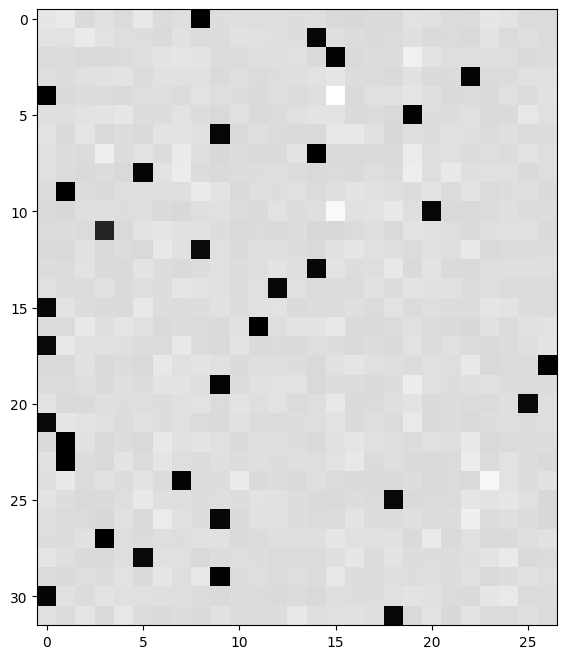

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

Observe only first row:


In [ ]:
print(F.softmax(logits, 1)[0])
print(dlogits[0])

tensor([0.0748, 0.0896, 0.0189, 0.0476, 0.0214, 0.0785, 0.0224, 0.0375, 0.0184,
        0.0320, 0.0353, 0.0364, 0.0359, 0.0298, 0.0339, 0.0147, 0.0095, 0.0187,
        0.0165, 0.0560, 0.0464, 0.0214, 0.0253, 0.0705, 0.0612, 0.0274, 0.0199],
       grad_fn=<SelectBackward0>)
tensor([ 0.0023,  0.0028,  0.0006,  0.0015,  0.0007,  0.0025,  0.0007,  0.0012,
        -0.0307,  0.0010,  0.0011,  0.0011,  0.0011,  0.0009,  0.0011,  0.0005,
         0.0003,  0.0006,  0.0005,  0.0018,  0.0015,  0.0007,  0.0008,  0.0022,
         0.0019,  0.0009,  0.0006], grad_fn=<SelectBackward0>)


The amount to which you mispredict is proportional to the strength of the "pull" produced by the gradient in that dimension. A completely correct prediction (prob=1 in the correct position and the rest of prob=0) will have all its gradients at 0. dlogits will be a rows of 0s for that example.

A confident misprediction is going to be pulled down heavily.


---------------

Exercise 3

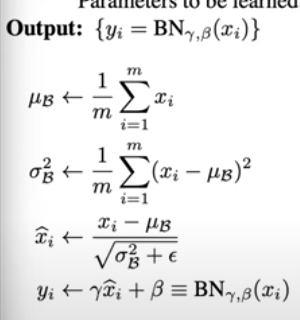

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  #loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  dlogits = F.softmax(logits, 1)
  dlogits[range(n), Yb] -= 1
  dlogits /= n
  # 2nd layer backprop
  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)
  # tanh
  dhpreact = (1.0 - h**2) * dh
  # batchnorm backprop
  dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
  dbnbias = dhpreact.sum(0, keepdim=True)
  dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
  # 1st layer
  dembcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0)
  # embedding
  demb = dembcat.view(emb.shape)
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
      ix = Xb[k,j]
      dC[ix] += demb[k,j]
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

In [ ]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))